### **Data Preparation**

Mounting Google Drive files


In [ ]:
#Mounting Google Drive files
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')

Mounted at /content/drive


Unzipping 

In [ ]:
#Unzipping the Dataset Required

import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/TFG/DataSets/FinalDataset.zip', 'r') as zip_ref:
    zip_ref.extractall('.')


In [ ]:
import os 
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt


#Saving the imgs and masks of full retin segmentation into two arrays
path = Path('/content/FinalDataset/')
imgs = [plt.imread(path/'RET'/'Img'/i)  for i in os.listdir(path/'RET'/'Img')]
masks = [plt.imread(path/'RET'/'masks'/i)  for i in os.listdir(path/'RET'/'masks')]


In [ ]:
#Saving shapes
shape_img = []
shape_mask = []
for i in range(len(imgs)): 
  shape_img.append(imgs[i].shape)
  shape_mask.append(masks[i].shape)

In [ ]:
#resize of the images (if not, they won't match leading to errors)
import cv2
for i in range(len(imgs)):
 imgs[i] = cv2.resize(imgs[i],(512,512))
 masks[i] = cv2.resize(masks[i],(512,512))


In [ ]:
#Conversion of masks images to int8 type

for i in range(len(masks)):
  masks[i] = masks[i].astype('int8')

In [ ]:
#Convert to numpy arrays
masks = np.array(masks)
imgs = np.array(imgs)

### **Network Architectures Definition**

UNet 


In [ ]:
#Definición de los bloques de la arquitectura UNET
import torch.nn.functional as F
import torch

def conv3x3_bn(ci,co):
  return torch.nn.Sequential(
      torch.nn.Conv2d(ci,co,3,padding=1),
      torch.nn.BatchNorm2d(co),
      torch.nn.ReLU(inplace=True)
  )

def encoder_conv(ci,co):
  return torch.nn.Sequential(
      torch.nn.MaxPool2d(2),
      conv3x3_bn(ci,co),
      conv3x3_bn(co,co)
  )

class deconv(torch.nn.Module):
  def __init__(self,ci,co):
    super(deconv,self).__init__()
    self.upsample = torch.nn.ConvTranspose2d(ci,co,2,stride=2)
    self.conv1 = conv3x3_bn(ci,co)
    self.conv2 = conv3x3_bn(co,co)

  def forward(self,x1,x2):
    x1 = self.upsample(x1)
    diffX = x2.size()[2] - x1.size()[2]
    diffY = x2.size()[3] - x1.size()[3]
    x1 = F.pad(x1, (diffX, 0, diffY, 0))
    x= torch.cat([x2,x1],dim=1)
    x= self.conv1(x)
    x= self.conv2(x)
    return x

class UNet(torch.nn.Module):
  def __init__(self,n_classes=2,in_ch=1):
    super().__init__()

    c = [32,64,128]

    self.conv1 = torch.nn.Sequential(
        conv3x3_bn(in_ch,c[0]),
        conv3x3_bn(c[0],c[0])
    )

    #capas del encoder
    self.conv2 = encoder_conv(c[0],c[1])
    self.conv3 = encoder_conv(c[1],c[2])

    #capas del decoder
    self.deconv1 = deconv(c[2],c[1])
    self.deconv2 = deconv(c[1],c[0])

    self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding = 1)

  def forward(self,x):
    #encoder
    x1 = self.conv1(x)
    x2 = self.conv2(x1)
    x3 = self.conv3(x2)
    #decoder
    x = self.deconv1(x3,x2)
    x = self.deconv2(x,x1)
    x = self.out(x)
    return x

Resnet50 

In [ ]:
from torchvision.models.segmentation import fcn_resnet50

resnet_50 = fcn_resnet50(pretrained=False, num_classes = 2, aux_loss = False ) 
resnet_50.backbone.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Resnet101

In [ ]:
from torchvision.models.segmentation import fcn_resnet101
resnet_101 = fcn_resnet101(pretrained=False, progress=True, num_classes=2, aux_loss=None)
resnet_101.backbone.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Deeplabv3_resnet50

In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet50
deeplabv3_resnet50_train =deeplabv3_resnet50(pretrained=False, progress=True, num_classes=2, aux_loss=None)
deeplabv3_resnet50_train.backbone.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

Deeplabv3_resnet101

In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet101
deeplabv3_resnet101_train =deeplabv3_resnet101(pretrained=False, progress=True, num_classes=2, aux_loss=None)
deeplabv3_resnet101_train.backbone.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

### **Data Augmentation Definition**





In [ ]:
import albumentations as A
transform = A.Compose([
    A.RandomSizedCrop(p=0.5, min_max_height=(480, 500), height=512, width=512, w2h_ratio=1.0, interpolation=0),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightness(p=0.5),
    A.Cutout(p=0.5,num_holes=1000,max_h_size=2,max_w_size=2),
    A.Blur(p=0.5, blur_limit=(3, 7)),
    A.Rotate(p=0.5, limit=(-10, 10))
])

### **Aceleracion GPU**

In [ ]:
#Aceleracion por GPU
device = "cuda" if torch.cuda.is_available() else "cpu"


### **DataSet Definition**



DataSet Class

In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, n_classes=2, augmentation=None):
    self.X = X
    self.y = y
    self.n_classes = n_classes
    self.augmentation = augmentation

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    img = self.X[ix]
    mask = self.y[ix]
    if self.augmentation:
      transformed = self.augmentation(image=img, mask=mask)
      img = transformed['image']
      mask = transformed['mask']
 
    #One hot
    mask = (np.arange(2) == mask[...,None]).astype(np.float32) 
    img = torch.tensor(img).unsqueeze(0) 
    return img, torch.from_numpy(mask).permute(2,0,1)

Definicion de Dataset y Dataloader

In [ ]:
#Definicion del dataset
#@title Dataset Definition

Train_Length =  800#@param {type:"number"}
Augmentation = False #@param {type:"boolean"}
if Augmentation==True: 
  data_aug = transform
else:
  data_aug = None
dataset = {
    'train': Dataset(imgs[:Train_Length], masks[:Train_Length], augmentation=data_aug),
    'test': Dataset(imgs[Train_Length:], masks[Train_Length:])
}

In [ ]:
#Definicion del dataloader
#@title Dataset Definition
#Con deeplabv3 el batch_size no puede ser 1

BatchSize =  2#@param {type:"number"}
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=BatchSize, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=BatchSize, pin_memory=True)
}

### **Metrics**

IoU

In [ ]:
#Métrica IoU
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))  
        union = (_out | _labs).float().sum((1, 2))         
        iou = (intersection + SMOOTH) / (union + SMOOTH)  
        ious.append(iou.mean().item())
    return np.mean(ious) 

Accuracy

In [ ]:
def accuracy(y_pred,batch_size,i):
  acc = []
  for j in range(batch_size):
    pred_mask = torch.argmax(y_pred[j], axis=0)
    pred_mask = np.array(pred_mask.cpu())
    masks_acc = masks[ ((i-1)*batch_size):(i*batch_size)]
    actual_mask = masks_acc[j]
    num = np.sum(np.array(pred_mask==actual_mask))  
    #NOTA: Quizás se puede contar dim de size para automatizar a cualquier tamaño
    a,b = pred_mask.shape
    den = a*b
    acc.append(num/den)
  return np.mean(acc)

### **Multiprocessing**

In [ ]:
#@title Multiprocessing (use if GPU not available) { vertical-output: true }
Multiprocessing = False    #@param {type:"boolean"}
if Multiprocessing==True:
  device = 'cpu'

### **Training function**

In [ ]:
from tqdm import tqdm

def fit(model, model_name, dataloader, epochs=10, lr=0.01, masks=masks, early_stopping=0):
    #Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    #Función de pérdida
    criterion = torch.nn.BCEWithLogitsLoss()

    model.to(device)
    hist = {'Loss': [], 'IoU': [], 'AccuracyScore': [], 'TestLoss': [], 'TestIoU': [], 'TestAcc': []}

    if early_stopping:
        step = 0
        best_acc, best_IoU, best_loss = 0,0,1e6
        weight_loss = 0.035

    for epoch in range(1, epochs+1):
      #Entrenamiento
      model.train()
      bar = tqdm(dataloader['train'])
      train_loss, train_iou, train_acc,CM_pred,CM_actual_CM,y_hat_CM,CM_array = [], [], [], [] , [] , [] , []
      i=0
      for imgs, mask_oh in bar:
        torch.cuda.empty_cache()
        i+=1
        # Guardar imagenes en GPU
        imgs, mask_oh = imgs.to(device), mask_oh.to(device)
        len_mask_oh = len(mask_oh)
        # Poner los gradientes a 0 porque si no son acumulativos
        optimizer.zero_grad()
        #Calculo de Output
        y_hat = model(imgs)
        
        #CUIDADO CON EL OUTPUT. ES DISTINTO DE LA UNET Y DE RESNET
        if model_name != 'UNet':
          y_hat = y_hat['out']
        #Métricas
        #Loss
        loss = criterion(y_hat, mask_oh)
        loss.backward()
        train_loss.append(loss.item())
        del loss
        #Accuracy
        train_acc.append(accuracy(y_hat,len_mask_oh,i))
        #IoU
        ious = iou(y_hat, mask_oh)
        train_iou.append(ious)
        del ious
        #Confusion Matrix
        #confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
        
        #Optimizacion
        optimizer.step()
        del imgs, mask_oh
       
        #Visualizar métricas
        #bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} accuracy {np.mean(train_acc):.5f}")
        #print(confusion_matrix)

        del y_hat
        torch.cuda.empty_cache()

      hist['Loss'].append(np.mean(train_loss))
      hist['IoU'].append(np.mean(train_iou))
      hist['AccuracyScore'].append(np.mean(train_acc))
      
      #Test
      model.eval()
      bar = tqdm(dataloader['test'])
      test_loss, test_iou, test_acc = [], [], []
      with torch.no_grad():
        i=0
        for imgs, mask_oh in bar:
          i+=1
          #Guardar imagenes en GPU
          imgs, mask_oh = imgs.to(device), mask_oh.to(device)
          len_mask_oh = len(mask_oh)
          #Calculo de output
          y_hat = model(imgs)
          if model_name != 'UNet':
            y_hat = y_hat['out']
          #Calculo de métricas
          #Loss
          loss = criterion(y_hat, mask_oh)
          test_loss.append(loss.item())
          del loss
          #Accuracy
          test_acc.append(accuracy(y_hat,len_mask_oh,i))
          #IoU
          ious = iou(y_hat, mask_oh)
          test_iou.append(ious)
          del ious
          #test_acc.append(acc)
          #bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f} test_acc {np.mean(test_acc):.5f}")
          
      hist['TestLoss'].append(np.mean(test_loss))
      hist['TestIoU'].append(np.mean(test_iou))
      hist['TestAcc'].append(np.mean(test_acc))
      print(f"\nEpoch {epoch}/{epochs} TrainLoss {np.mean(train_loss):.5f} TrainIoU {np.mean(train_iou):.5f} TrainAccuracy {np.mean(train_acc):.5f} TestLoss {np.mean(test_loss):.5f} TestIoU {np.mean(test_iou):.5f} TestAcc {np.mean(test_acc):.5f} Learning Rate {lr}")
      
      best_metric = (best_loss)**-1*weight_loss + best_IoU + best_acc
      actual_metric = ((hist['TestLoss'][-1])**-1*weight_loss + hist['TestIoU'][-1] + hist['TestAcc'][-1])
      #print(actual_metric,best_metric)
      #Early stopping code
      if actual_metric > best_metric:
          #print(best_metric,(best_loss)**-1*weight_loss)
          best_loss, best_IoU, best_acc = hist['TestLoss'][-1], hist['TestIoU'][-1], hist['TestAcc'][-1]
          print(f'Best model saved with learning rate {lr} in epoch {epoch}')
          torch.save(model.state_dict(), f'{model_name}_lr_{lr}.pt')
         
          step = 0
      else:
          step+=1
      if step>early_stopping: 
          print(f'Code stopped by early stopping. Best metrics are: TestAccuracy: {best_acc}, TestLoss: {best_loss}, TestIoU: {best_IoU}')
          break
          #break exits de epoch loop
    #Load best parameters in model (Hacer esto al evaluar segun learning rate, ya que tendré varios modelos, no me interesa cargarlo ahora)
    model.load_state_dict(torch.load(f'{model_name}_lr_{lr}.pt'))
    model.to('cpu')
    torch.cuda.empty_cache()
    return hist,best_loss,best_IoU,best_acc


In [ ]:
from tqdm import tqdm

def fit_multi(model, model_name, dataloader, epochs=10, lr=0.01, masks=masks, early_stopping=0):
    #torch.cuda.empty_cache()
    #Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    #Función de pérdida
    criterion = torch.nn.BCEWithLogitsLoss()

    #model.to(device)
    hist = {'Loss': [], 'IoU': [], 'AccuracyScore': [], 'TestLoss': [], 'TestIoU': [], 'TestAcc': []}

    if early_stopping:
        step = 0
        best_acc, best_IoU, best_loss = 0,0,1e6
        weight_loss = 0.035

    for epoch in range(1, epochs+1):
      #Entrenamiento
      model.train()
      #bar = tqdm(dataloader['train'])
      #For multiprocessing, change to only dataloader
      bar = tqdm(dataloader)
      train_loss, train_iou, train_acc,CM_pred,CM_actual_CM,y_hat_CM,CM_array = [], [], [], [] , [] , [] , []
      i=0
      for imgs, mask_oh in bar:
        i+=1
        # Guardar imagenes en GPU
        #imgs, mask_oh = imgs.to(device), mask_oh.to(device)
        len_mask_oh = len(mask_oh)
        # Poner los gradientes a 0 porque si no son acumulativos
        optimizer.zero_grad()
        #Calculo de Output
       
        y_hat = model(imgs)
        
        #CUIDADO CON EL OUTPUT. ES DISTINTO DE LA UNET Y DE RESNET
        if model_name != 'UNet':
          y_hat = y_hat['out']
        #Métricas
        #Loss
        loss = criterion(y_hat, mask_oh)
        loss.backward()
        train_loss.append(loss.item())
        del loss
        #Accuracy
        train_acc.append(accuracy(y_hat,len_mask_oh,i))
        #IoU
        ious = iou(y_hat, mask_oh)
        train_iou.append(ious)
        del ious
       
        #Optimizacion
        optimizer.step()
        del imgs, mask_oh
       
        #Visualizar métricas
        #bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} accuracy {np.mean(train_acc):.5f}")
        #print(confusion_matrix)

        del y_hat

      hist['Loss'].append(np.mean(train_loss))
      hist['IoU'].append(np.mean(train_iou))
      hist['AccuracyScore'].append(np.mean(train_acc))
      
      #Test
      model.eval()
      #bar = tqdm(dataloader['train'])
      #For multiprocessing, change to only dataloader
      bar = tqdm(dataloader)
      test_loss, test_iou, test_acc = [], [], []
      with torch.no_grad():
        i=0
        for imgs, mask_oh in bar:
          i+=1
          #Guardar imagenes en GPU
          #imgs, mask_oh = imgs.to(device), mask_oh.to(device)
          len_mask_oh = len(mask_oh)
          #Calculo de output
          y_hat = model(imgs)
          if model_name != 'UNet':
            y_hat = y_hat['out']
          #Calculo de métricas
          #Loss
          loss = criterion(y_hat, mask_oh)
          test_loss.append(loss.item())
          del loss
          #Accuracy
          train_acc.append(accuracy(y_hat,len_mask_oh,i))
          del acc
          #IoU
          ious = iou(y_hat, mask_oh)
          test_iou.append(ious)
          del ious
          #bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f} test_acc {np.mean(test_acc):.5f}")
          
      hist['TestLoss'].append(np.mean(test_loss))
      hist['TestIoU'].append(np.mean(test_iou))
      hist['TestAcc'].append(np.mean(test_acc))
      print(f"\nEpoch {epoch}/{epochs} TrainLoss {np.mean(train_loss):.5f} TrainIoU {np.mean(train_iou):.5f} TrainAccuracy {np.mean(train_acc):.5f} TestLoss {np.mean(test_loss):.5f} TestIoU {np.mean(test_iou):.5f} TestAcc {np.mean(test_acc):.5f} Learning Rate {lr}")
      
      best_metric = (best_loss)**-1*weight_loss + best_IoU + best_acc
      actual_metric = ((hist['TestLoss'][-1])**-1*weight_loss + hist['TestIoU'][-1] + hist['TestAcc'][-1])
      #Early stopping code
      if actual_metric > best_metric:
          best_loss, best_IoU, best_acc = hist['TestLoss'][-1], hist['TestIoU'][-1], hist['TestAcc'][-1]
          print(f'Best model saved with learning rate {lr} in epoch {epoch}')
          torch.save(model.state_dict(), f'{model_name}_lr_{lr}.pt')
          step = 0
      else:
          step+=1
      if step>early_stopping: 
          print(f'Code stopped by early stopping. Best metrics are: TestAccuracy: {best_acc}, TestLoss: {best_loss}, TestIoU: {best_IoU}')
          break
          #break exits de epoch loop
    #Load best parameters in model (Hacer esto al evaluar segun learning rate, ya que tendré varios modelos, no me interesa cargarlo ahora)
    model.load_state_dict(torch.load(f'{model_name}_lr_{lr}.pt'))
    #model.to('cpu')
    #torch.cuda.empty_cache()
    return hist,best_loss,best_IoU,best_acc

### **Model training**

In [ ]:
#Entrenamiento del modelo
#@title Training Parameters { vertical-output: true }

#import ipywidgets as widgets
#from IPython.display import display

ModelArchitecture = "UNet" #@param ["UNet", "resnet_50", "resnet_101", "deeplabv3_resnet50", "deeplabv3_resnet101"]
LearningRate =  0.1#@param {type:"number"}
Epochs =  15#@param {type:"number"}
EarlyStopping =  5#@param {type:"number"}
params = {'model': '', 'model_name': ModelArchitecture, 'lr': LearningRate, 'epochs': Epochs, 'early_stopping': EarlyStopping}


if ModelArchitecture=='UNet':
  U = UNet()
  params['model'] = U
elif ModelArchitecture=='resnet_50':
  params['model']  = resnet_50
elif ModelArchitecture=='resnet_101':
  params['model']  = resnet_101
elif ModelArchitecture=='deeplabv3_resnet50':
  params['model']  = deeplabv3_resnet50_train
elif ModelArchitecture=='deeplabv3_resnet101':
  params['model']  = deeplabv3_resnet101_train

In [ ]:
from google.colab import files

if (__name__ == '__main__') and (device=='cpu'):
  import multiprocessing as mp
  num_processes = mp.cpu_count()
  model = params['model']
  model_name = params['model_name']
  model.share_memory()
  processes = []
  for rank in range(num_processes):
      data_loader = torch.utils.data.DataLoader(
          dataset=dataset['train'],
          sampler=torch.utils.data.DistributedSampler(
              dataset=dataset['train'],
              num_replicas=num_processes,
              rank=rank
          ),
          batch_size=BatchSize
      )
      p = mp.Process(target=fit_multi, args=(model, model_name, data_loader, 10, 0.01, 10))
      p.start()
      processes.append(p)
  for p in processes:
      try:
            p.join()
      except: 
        continue
  files.download(f'/content/{ModelArchitecture}_lr_{LearningRate}.pt')

  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|          | 1/200 [01:53<6:14:54, 113.04s/it]

NameError: ignored

In [ ]:
from google.colab import files
hist = []
if Multiprocessing==False:
  historial,best_loss,best_IoU,best_acc = fit(params['model'], params['model_name'], dataloader, params['epochs'], lr=params['lr'], masks=masks, early_stopping=params['early_stopping'])
  hist.append(historial)
  if len(hist)!=0:
    files.download(f'/content/{ModelArchitecture}_lr_{LearningRate}.pt')

###**Reshape predictions to original shape** 

In [ ]:
def original_shape(model,model_name, img_prediction, index, archivo=False):
  import cv2
  import matplotlib.pyplot as plt
  output_masks = []
  if archivo:
    model.load_state_dict(torch.load(archivo))
  model.to(device)
  model.eval()
  with torch.no_grad():
      img = torch.tensor(img_prediction).to(device)
      if model_name == 'UNet':
        output = model(img.unsqueeze(0).unsqueeze(0))[0]
      else:
        output = model(img.unsqueeze(0).unsqueeze(0))['out']
      pred_mask = torch.argmax(output, axis=0)
      pred_mask = np.array(pred_mask.cpu()).astype('float32')
      output = cv2.resize(pred_mask,(shape_img[index][1],shape_img[index][0]))
      output_mask.append(output)
  return output_mask

In [ ]:
import torch
results = original_shape(params['model'],params['model_name'], imgs[0], 0)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


NameError: ignored

### **Results Visualization**

Metrics Evolution Graphics

In [ ]:
import pandas as pd
import matplotlib
#It downloads the image of the graphic
for i in range(len(hist)):
  df = pd.DataFrame(hist[i])
  df.plot(grid=True,figsize=(10,3),xlabel='Epochs')
  matplotlib.pyplot.savefig(f'{ModelArchitecture}_{LearningRate}.png')
  files.download(f'{ModelArchitecture}_{LearningRate}.png')


Saving Model Data and Metrics in .txt

In [ ]:
UploadResultsFile = True #@param {type:"boolean"}


In [ ]:
if UploadResultsFile == True:
  from google.colab import files
  archivo = files.upload()

In [ ]:
#open('Results.txt', 'x')
f = open('Results.txt', 'a')
f.write(f'\nModel:{ModelArchitecture}, BatchSize:{BatchSize}, Learning rate:{LearningRate}, Epochs:{Epochs}, Early Stopping:{EarlyStopping}, Train Dataset Length:{Train_Length}, Data Augmentation:{Augmentation}\nTest Loss:{best_loss}, Test IoU:{best_IoU}, Test Accuracy:{best_acc}')
f.close()
files.download('Results.txt')
#f = open('Results.txt', 'r')
#print(f.read())

NameError: ignored

Visualize predicted masks

In [ ]:
pretrained_list = []
pretrained_list = [i for i in os.listdir('/content/drive/MyDrive/TFG/Modelos/Models Bilayer/Pretrained')]
params = {'model':'', 'model_name':''}

In [ ]:
#@title Do you want to upload a model?
YesUploadModel = True #@param {type:"boolean"}
if Yes:
  for i in pretrained_list: 
    print('\n' + i)
  #@markdown Select the architecture (must coincide with the one in Insert)
  Architecture = "resnet_50" #@param ["UNet", "resnet_50", "resnet_101", "deeplabv3_resnet50", "deeplabv3_resnet101"]
  #@markdown Available models are shown below if 'Yes' is selected. Copy and insert the name in the 'Insert' tag
  Insert = 'resnet_50_lr_0.1_Augmentation_False_Batch_12_Epochs_50_Early_10_TDLength_800 .pt' #@param {type:"string"}
  params['model_name'] = Architecture

  if params['model_name']=='UNet':
    U = UNet()
    params['model'] = U
  if params['model_name']=='resnet_50':
    params['model']  = resnet_50
  elif params['model_name']=='resnet_101':
    params['model']  = resnet_101
  elif params['model_name']=='deeplabv3_resnet50':
    params['model']  = deeplabv3_resnet50_train
  elif params['model_name']=='deeplabv3_resnet101':
    params['model']  = deeplabv3_resnet101_train


UNet_lr_0.1_Augmentation_True_Batch_12_Epochs_50_Early_10_TDLength_800.pt

UNet_lr_0.1_Augmentation_False_Batch_12_Epochs_50_Early_10_TDLength_800 .pt

resnet_50_lr_0.1_Augmentation_False_Batch_12_Epochs_50_Early_10_TDLength_800 .pt

resnet_50_lr_0.1_Augmentation_True_Batch_12_Epochs_50_Early_10_TDLength_800 .pt

resnet_101_lr_0.1_Augmentation_True_Batch_6_Epochs_50_Early_10_TDLength_800 .pt

resnet_101_lr_0.1_Augmentation_False_Batch_6_Epochs_50_Early_10_TDLength_800.pt

deeplabv3_resnet50_lr_0.1.pt


In [ ]:
#This will be the path to file
pretrained_model_path = '/content/drive/MyDrive/TFG/Modelos/Models Bilayer/Pretrained/' + Insert

In [ ]:
#Evaluacion visual de resultados
def visual_eval(model, model_name, archivo=False):
  if YesUploadModel:
    pretrained = torch.load(pretrained_model_path,map_location=torch.device('cpu'))
    model.load_state_dict(pretrained)  
  model.eval()
  model.to(device)
  import random
  font1 = {'family':'serif','color':'blue','size':20}
  with torch.no_grad():
    fig, axes = plt.subplots(2, 3, figsize=(18,6))
    for i in range(2):
     random_number = random.randint(0, ( len(imgs)-1 ))
     if model_name == 'UNet':
        output = model(torch.tensor(imgs[random_number]).unsqueeze(0).unsqueeze(0).to(device)) #[0]
     else:
        output = model(torch.tensor(imgs[random_number]).unsqueeze(0).unsqueeze(0).to(device))['out']
     pred_mask = torch.argmax(output.squeeze(0), axis=0) #axis 0 lo hace en la dim del numero de imagenes (2) tomando los máximos de cada paraja de pixeles
     axes[i,0].imshow(imgs[random_number])
     axes[i,0].set_title("Image",fontsize=20)
     axes[i,0].set_yticks([])
     axes[i,0].set_xticks([])
     axes[i,1].imshow(masks[random_number],cmap='gray')
     axes[i,1].set_title("Mask",fontsize=20)
     axes[i,1].set_yticks([])
     axes[i,1].set_xticks([])
     axes[i,2].imshow(np.array(pred_mask.cpu()),cmap='gray')
     axes[i,2].set_title("Prediction",fontsize=20)
     axes[i,2].set_yticks([])
     axes[i,2].set_xticks([])
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

    plt.show()


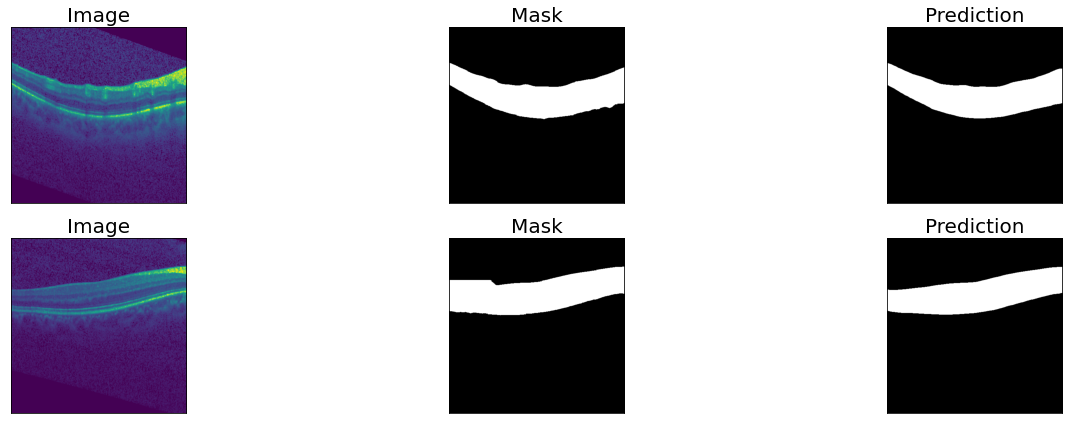

In [ ]:
visual_eval(params['model'], params['model_name'])